In [23]:
# -*- coding: utf-8 -*-
"""
This code is highly based on the codes : 

data_overview_1.py, data_overview_2.py, and example_nix.py from 

This repository contains the datasets described in the publication Brochier et al. (2018). 
Massively parallel recordings in macaque motor cortex during an instructed delayed 
reach-to-grasp task, Scientific Data, 5, 180055. http://doi.org/10.1038/sdata.2018.55

available repository at: https://gin.g-node.org/INT/multielectrode_grasp

These codes were modified and combined by Julie Lanthier in order to manipulate
the data from the nix files, and achieve the Brainhack project.

Large parts of the codes were used. These are presented with the mention below.

#############################################################################

Code for generating the first data figure in the manuscript.

Authors: Julia Sprenger, Lyuba Zehl, Michael Denker


Copyright (c) 2017, Institute of Neuroscience and Medicine (INM-6),
Forschungszentrum Juelich, Germany
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
list of conditions and the following disclaimer.
* Redistributions in binary form must reproduce the above copyright notice,
this list of conditions and the following disclaimer in the documentation
and/or other materials provided with the distribution.
* Neither the names of the copyright holders nor the names of the contributors
may be used to endorse or promote products derived from this software without
specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

#############################################################################
Code for generating the second data figure in the manuscript.

Authors: Julia Sprenger, Lyuba Zehl, Michael Denker


Copyright (c) 2017, Institute of Neuroscience and Medicine (INM-6),
Forschungszentrum Juelich, Germany
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
list of conditions and the following disclaimer.
* Redistributions in binary form must reproduce the above copyright notice,
this list of conditions and the following disclaimer in the documentation
and/or other materials provided with the distribution.
* Neither the names of the copyright holders nor the names of the contributors
may be used to endorse or promote products derived from this software without
specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

#############################################################################
Example code for loading and processing of a recording of the reach-
to-grasp experiments conducted at the Institute de Neurosciences de la Timone
by Thomas Brochier and Alexa Riehle from the NIX files.

Authors: Julia Sprenger, Lyuba Zehl, Michael Denker


Copyright (c) 2017, Institute of Neuroscience and Medicine (INM-6),
Forschungszentrum Juelich, Germany
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
list of conditions and the following disclaimer.
* Redistributions in binary form must reproduce the above copyright notice,
this list of conditions and the following disclaimer in the documentation
and/or other materials provided with the distribution.
* Neither the names of the copyright holders nor the names of the contributors
may be used to endorse or promote products derived from this software without
specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

"""

In [ ]:
import os

import csv

import numpy as np
from scipy import stats
import quantities as pq
import matplotlib.pyplot as plt
from matplotlib import gridspec, ticker

from reachgraspio import reachgraspio
import odml.tools
from neo import utils as neo_utils
from neo_utils import load_segment
import odml_utils

# Imports from example_nix.py
from neo import Block, Segment
from neo.io import NixIO
from neo.utils import cut_segment_by_epoch, add_epoch, get_events

# Imports for the classifiere
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

# Data loading and features extraction
***

**Run the cells only if you have downloaded the nix files from *https://gin.g-node.org/INT/multielectrode_grasp*.**

#### First, we load and prepare the data.

In [ ]:
# =============================================================================
# Define data and metadata directories
# =============================================================================


def get_monkey_datafile(monkey):
    if monkey == "Lilou":
        return "l101210-001"  # ns2 (behavior) and ns5 present
    elif monkey == "Nikos2":
        return "i140703-001"  # ns2 and ns6 present
    else:
        return ""

# Enter your dataset directory here
datasetdir = "../multielectrode_grasp/datasets_blackrock/"

trialtype_colors = {
    'SGHF': 'MediumBlue', 'SGLF': 'Turquoise',
    'PGHF': 'DarkGreen', 'PGLF': 'YellowGreen',
    'LFSG': 'Orange', 'LFPG': 'Yellow',
    'HFSG': 'DarkRed', 'HFPG': 'OrangeRed',
    'SGSG': 'SteelBlue', 'PGPG': 'LimeGreen',
    'NONE': 'k', 'PG': 'k', 'SG': 'k', 'LF': 'k', 'HF': 'k'}

event_colors = {
    'TS-ON': 'Gray',  # 'TS-OFF': 'Gray',
    'WS-ON': 'Gray',  # 'WS-OFF': 'Gray',
    'CUE-ON': 'Gray',
    'CUE-OFF': 'Gray',
    'GO-ON': 'Gray',  # 'GO-OFF': 'Gray',
    #    'GO/RW-OFF': 'Gray',
    'SR': 'Gray',  # 'SR-REP': 'Gray',
    'RW-ON': 'Gray',  # 'RW-OFF': 'Gray',
    'STOP': 'Gray'}



In [ ]:
# =============================================================================
# Load data and metadata for a monkey
# =============================================================================
# CHANGE this parameter to load data of the different monkeys
#monkey = 'Nikos2'
monkey = 'Lilou'


In [ ]:
# =============================================================================
# Load data
#
# As a first step, we load the data file into memory as a Neo object.
# =============================================================================

# Specify the datafile
datafile = get_monkey_datafile(monkey)

# Specify the path to the recording session to load, eg,
session_path = os.path.join("..", "multielectrode_grasp","datasets_nix", datafile + ".nix")

# Open the session for reading
session = NixIO(session_path)


# Read the complete dataset in lazy mode generating all neo objects,
# but not loading data into memory.  The lazy neo structure will contain objects
# to capture all recorded data types (time series at 1000Hz (ns2) and 30kHz (ns6)
# scaled to units of voltage, sorted spike trains, spike waveforms and events)
# of the recording session and return it as a Neo Block. The
# time shift of the ns2 signal (LFP) induced by the online filter is
# automatically corrected for by a heuristic factor stored in the metadata
# (correct_filter_shifts=True).

block = session.read_block()

# Validate there is only a single Segment present in the block
assert len(block.segments) == 1

# Loading data content of the segment
segment = block.segments[0]

print("Session loaded.")

In [ ]:
# =============================================================================
# Uses the events to define the trials
#
# =============================================================================

# get start and stop events of trials
start_events = neo_utils.get_events(
    segment,
    **{
    'name': 'TrialEvents',
    'trial_event_labels': 'TS-ON',
    'performance_in_trial': 255})


stop_events = neo_utils.get_events(
    segment,
    **{
    'name': 'TrialEvents',
    'trial_event_labels': 'STOP',
    'performance_in_trial': 255})

# there should only be one event object for these conditions
assert len(start_events) == 1
assert len(stop_events) == 1

# insert epochs corresponding to trials
ep = neo_utils.add_epoch(
    segment,
    start_events[0],
    stop_events[0],
    pre=0 * pq.ms, 
    post=0 * pq.ms, 
    trial_status='complete_trials')
ep.array_annotate(trial_type=start_events[0].array_annotations['belongs_to_trialtype'],
                  trial_performance=start_events[0].array_annotations['performance_in_trial'])


epochs = neo_utils.get_epochs(segment, **{'trial_status': 'complete_trials'})
assert len(epochs) == 1

In [ ]:
# use most raw neuronal data if multiple versions are present
max_sampling_rate = max([a.sampling_rate for a in segment.analogsignals])
idx = 0
while idx < len(segment.analogsignals):
    signal = segment.analogsignals[idx]
    if signal.annotations['neural_signal'] and signal.sampling_rate < max_sampling_rate:
        segment.analogsignals.pop(idx)
    else:
        idx += 1

# cut segments according to inserted 'complete_trials' epochs and reset trial times
cut_segments = neo_utils.cut_segment_by_epoch(segment, epochs[0], reset_time=True)


#### Now, we extract the features from the data of the training electrode and the ten testing electrodes for the analyzes 1 (rest and movement).

In [ ]:
# =============================================================================
# Feature and label extractions from data
# =============================================================================

# Determine a time windows to slide on the data
window = 1000 # ms 
window_len = window/1000*30000 # Number of points @ 30kHz
window_time = (window * pq.ms).rescale(pq.s) # Window size in second

# Passing through all segments with the time window, at each time frame, extract 
# the feature (1 value) and the label (rest or mvt). Write values in a csv file.

# Electrodes
if monkey == 'Nikos2':
    electrodes = [2, 12, 41, 45, 59] # Random testing electrodes for Nikos
elif monkey == 'Lilou':
    electrodes = [4, 32, 45, 54, 73, 81] # Random testing electrodes for Lilou + 1 training electrode (el. 4)

# Features
feature1 = 'mean_seg'
feature2 = 'max-min'

# Loop on every electrode
for electrode in electrodes :
    
    # Open a csv file in exclusive creating mode
    with open('features/'+feature1+'_'+feature2+'_el_'+str(electrode)+'_'+monkey+'_TW_'+str(window)+'.csv', mode='x') as fobj:
        writer = csv.writer(fobj)
        writer.writerow(['id_segment', 'label', feature1, feature2]) 
        for index, seg in enumerate(cut_segments) :
            
            # Calculate the number of resting frames in the segment
            for events in seg.events:
                if 'GO-ON' in events.labels :
                    start_arg = np.where(events.labels=='TS-ON')[0][0]
                    start_time = events.times[start_arg]
                    go_arg = np.where(events.labels=='GO-ON')[0][0]
                    go_time = events.times[go_arg]
                    stop_arg = np.where(events.labels=='STOP')[0][0]
                    stop_time = events.times[stop_arg]
            frames_rest = round((go_time - start_time)/window_time).item()    

            # Extract raw data of the segment
            raw_data = [a for a in seg.analogsignals if a.annotations['neural_signal']]
            assert len(raw_data) == 1
            raw_data = raw_data[0]
            raw_signal = raw_data[:, electrode]
    
            # Slide the window throught the data of the segment to extract features and labels
            for frame in range(int(np.floor(len(raw_signal)/window_len))) :
                data_window = raw_signal[int(np.floor(frame*window_len)):int(np.floor((frame+1)*window_len))]
                
                # Extract feature for the window
                mean_seg = np.mean(data_window)
                max_min = max(data_window) - min(data_window)
                    
                # Extract label
                if frame<frames_rest:
                    label = 'rest'
                else:
                    label = 'mvt'
    
                # Write in csv file
                writer.writerow([index, label, mean_seg, max_min]) 
    


#### Re-run all the above cells for monkey Nikos to generate the necessary csv files for testing.

#### Then, with the next cell, we write a last csv file for the testing of analyzes 2 (rest, reach-grasp, and pull).

In [ ]:
# =============================================================================
# Feature and label extractions from data
# =============================================================================

# Determine a time windows to slide on the data
window = 250 # ms
window_len = window/1000*30000 # Number of points @ 30kHz
window_time = (window * pq.ms).rescale(pq.s) # Window size in second

# Passing through all segments with the time window, at each time frame, extract 
# the feature (1 value) and the label (rest or mvt). Write values in a csv file.

# Electrode
electrodes = [77]

# Features
feature1 = 'mean_seg'
feature2 = 'max-min'
feature3 = 'mean_diff'

# Loop on every electrode
for electrode in electrodes :
    
    # Open a csv file in exclusive creating mode
    with open('features/rest_all_mvts_el_'+str(electrode)+'_'+monkey+'_TW_'+str(window)+'.csv', mode='x') as fobj:
        writer = csv.writer(fobj)
        writer.writerow(['id_segment', 'label', feature1, feature2, feature3]) 
        for index, seg in enumerate(cut_segments) :
            
            # Calculate the number of resting frames in the segment
            for events in seg.events:
                if 'RW-ON' in events.labels :
                    start_arg = np.where(events.labels=='TS-ON')[0][0]
                    start_time = events.times[start_arg]
                    sr_arg = np.where(events.labels=='SR')[0][0]
                    sr_time = events.times[sr_arg]
                    ot_arg = np.where(events.labels=='OT')[0][0]
                    ot_time = events.times[ot_arg]
                    od_arg = np.where(events.labels=='DO')[0][0]
                    od_time = events.times[od_arg]
                    rw_arg = np.where(events.labels=='RW-ON')[0][0]
                    rw_time = events.times[rw_arg]
                    pull_time = rw_time-(0.5 * pq.s) # verfifier s *************************
                    fsroff_arg = np.where(events.labels=='FSRplat-OFF')[0][0]
                    fsroff_time = events.times[fsroff_arg]
                    or_arg = np.where(events.labels=='OR')[0][0]
                    or_time = events.times[or_arg]
                    stop_arg = np.where(events.labels=='STOP')[0][0]
                    stop_time = events.times[stop_arg]
            frames_rest = round((sr_time - start_time)/window_time).item()
            frames_reach = round((ot_time - start_time)/window_time).item()
            frames_grasp = round((od_time - start_time)/window_time).item()
            frames_pull = round((pull_time - start_time)/window_time).item()
            frames_hold = round((fsroff_time - start_time)/window_time).item()
            frames_replace = round((or_time - start_time)/window_time).item()

            # Extract raw data of the segment
            raw_data = [a for a in seg.analogsignals if a.annotations['neural_signal']]
            assert len(raw_data) == 1
            raw_data = raw_data[0]
            raw_signal = raw_data[:, electrode]
    
            # Slide the window throught the data of the segment to extract features and labels
            for frame in range(int(np.floor(len(raw_signal)/window_len))) :
                data_window = raw_signal[int(np.floor(frame*window_len)):int(np.floor((frame+1)*window_len))]
                
                # Extract feature for the window
                mean_seg = np.mean(data_window)
                max_min = max(data_window) - min(data_window)
                mean_diff = np.mean(data_window[int(window_len/2):-1])-np.mean(data_window[0:int(window_len/2)])
                    
                # Extract label
                if frame<frames_rest:
                    label = 'rest'
                elif frames_rest<=frame<frames_reach:
                    label = 'reach'
                elif frames_reach<=frame<frames_grasp:
                    label = 'grasp'
                elif frames_grasp<=frame<frames_pull:
                    label = 'pull'
                elif frames_pull<=frame<frames_hold:
                    label = 'hold'
                elif frames_hold<=frame<frames_replace:
                    label = 'replace'
                else:
                    label = 'release'
    
                # Write in csv file
                writer.writerow([index, label, mean_seg, max_min, mean_diff]) 
    


# Analyzes 1 : Classify rest and movements
***

#### First, let's read the csv file we made to extract the features and labels.

In [24]:
path = "features/"
filename = 'mean_seg_max-min_el_4_Lilou_TW_1000'

rest_mean_seg = []
rest_max_min = []
mvt_mean_seg = []
mvt_max_min = []
labels = []
features = []

with open(path+filename+".csv",encoding="utf-8") as fobj: 
    reader = csv.reader(fobj) 
    colonnes = next(reader)
    idx_label = colonnes.index('label')
    idx_mean_seg = colonnes.index('mean_seg')
    idx_max_min = colonnes.index('max-min')
    idx_id_seg = colonnes.index('id_segment')

    for row in reader: 
        label = row[idx_label]
        mean_seg = float(row[idx_mean_seg][0:-3])
        max_min = float(row[idx_max_min][1:-4])
        id_seg = row[idx_id_seg]

        if label == 'rest':
            rest_mean_seg.append(mean_seg)
            rest_max_min.append(max_min)
        elif label == 'mvt':
            mvt_mean_seg.append(mean_seg)
            mvt_max_min.append(max_min)

        labels.append(label)
        features.append(np.array([mean_seg, max_min]))


Now, let's look at these features, to assess if they are relevant to separate the rest and the movement conditions.

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
/var/folders/8y/npl9c12x1pjf4438s29r9_9c0000gn/T/ipykernel_62552/3960284030.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Feature 1 : mean ($\mu V$)')
/var/folders/8y/npl9c12x1pjf4438s29r9_9c0000gn/T/ipykernel_62552/3960284030.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Feature 2 : max-min ($\mu V$)')


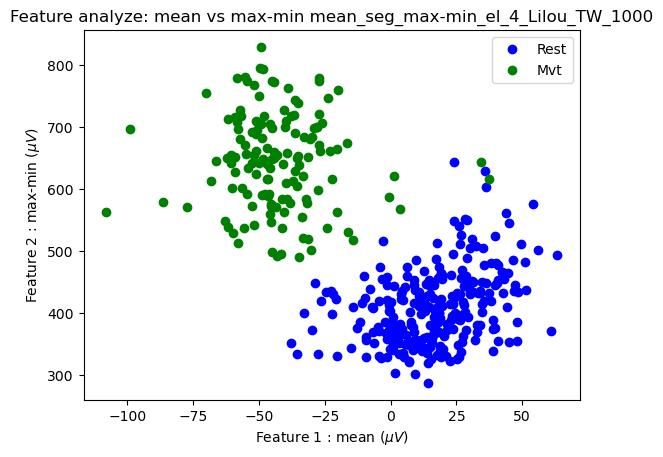

In [25]:
# Plotting to visualise features

plt.figure()
plt.plot(rest_mean_seg, rest_max_min, 'bo', label = 'Rest')
plt.plot(mvt_mean_seg, mvt_max_min, 'go', label = 'Mvt')
plt.xlabel('Feature 1 : mean ($\mu V$)')
plt.ylabel('Feature 2 : max-min ($\mu V$)')
plt.title('Feature analyze: mean vs max-min '+filename)
plt.legend()
#plt.savefig('figures/Feature_analyze_'+filename+'.png')


#### Let's train our model! 

In [26]:
# Training the model on Lilou el.4 data

# Implementation
clf1 = LinearDiscriminantAnalysis()

# Training
clf1.fit(features, labels)

# Score (to give an idea of the separability of the data)
print(clf1.score(features, labels))

0.9902439024390244


#### Let's test the model on other electrodes! 

mean_seg_max-min_el_32_Lilou_TW_1000
Accuracy: 0.6853658536585366
##########################################################################################
mean_seg_max-min_el_45_Lilou_TW_1000


<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:56: SyntaxWarning: invalid escape sequence '\m'
<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:56: SyntaxWarning: invalid escape sequence '\m'
/var/folders/8y/npl9c12x1pjf4438s29r9_9c0000gn/T/ipykernel_62552/2170156084.py:55: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Feature 1 : mean ($\mu V$)')
/var/folders/8y/npl9c12x1pjf4438s29r9_9c0000gn/T/ipykernel_62552/2170156084.py:56: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Feature 2 : max-min ($\mu V$)')


Accuracy: 0.9878048780487805
##########################################################################################
mean_seg_max-min_el_54_Lilou_TW_1000
Accuracy: 0.9878048780487805
##########################################################################################
mean_seg_max-min_el_73_Lilou_TW_1000
Accuracy: 0.6951219512195121
##########################################################################################
mean_seg_max-min_el_81_Lilou_TW_1000
Accuracy: 0.9365853658536586
##########################################################################################
mean_seg_max-min_el_2_Nikos2_TW_1000
Accuracy: 0.8708920187793427
##########################################################################################
mean_seg_max-min_el_12_Nikos2_TW_1000
Accuracy: 0.6666666666666666
##########################################################################################
mean_seg_max-min_el_41_Nikos2_TW_1000
Accuracy: 0.6807511737089202
###########################

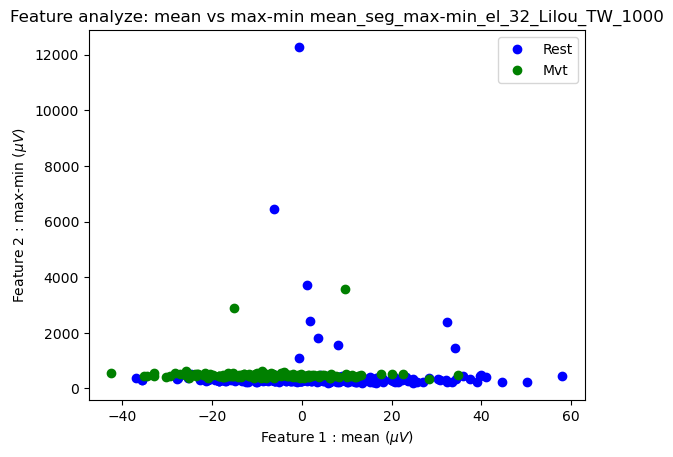

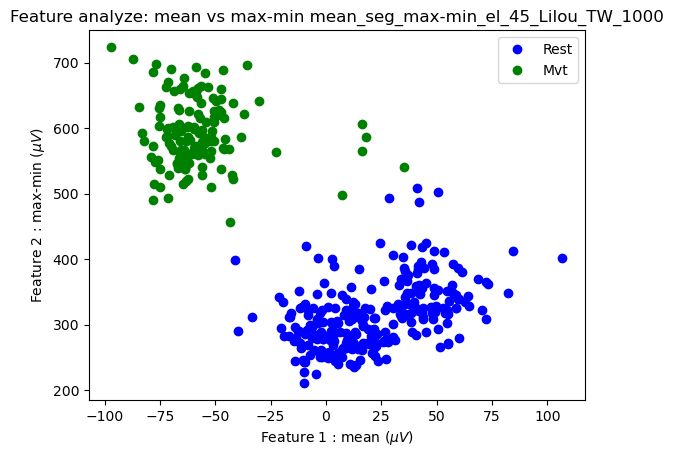

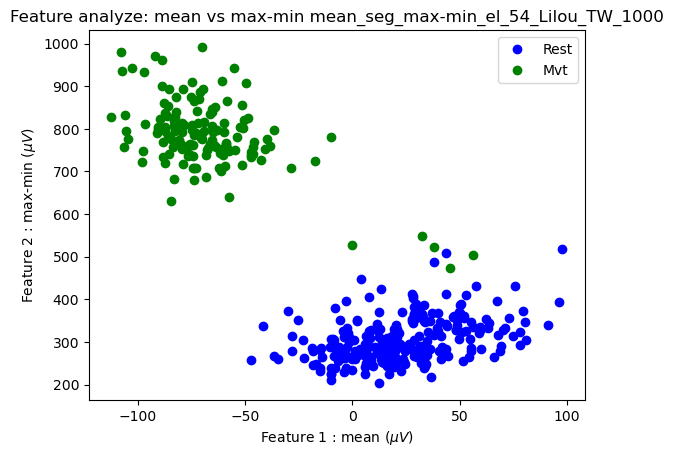

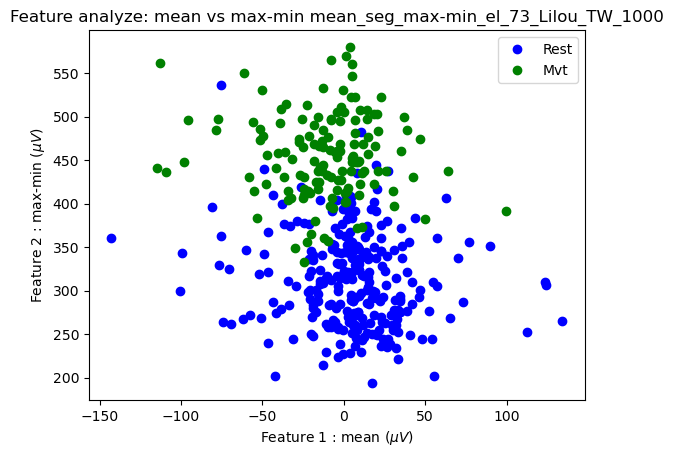

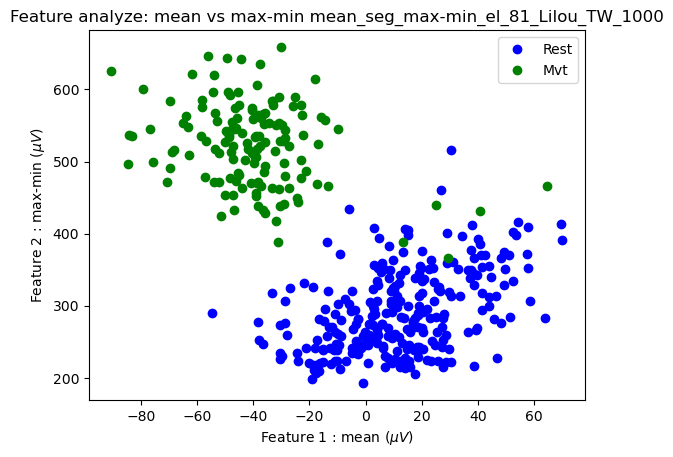

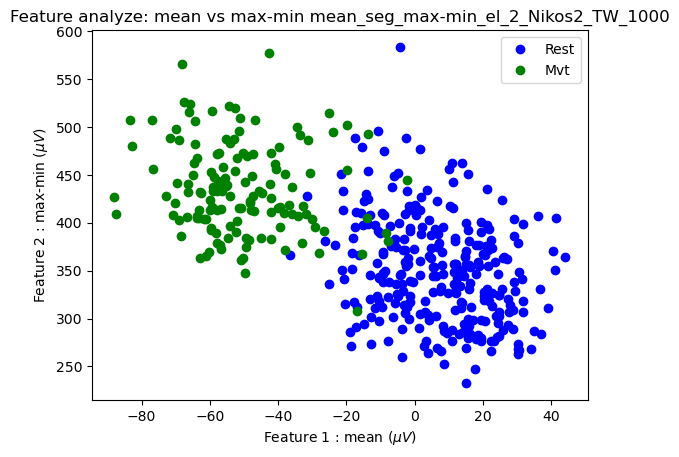

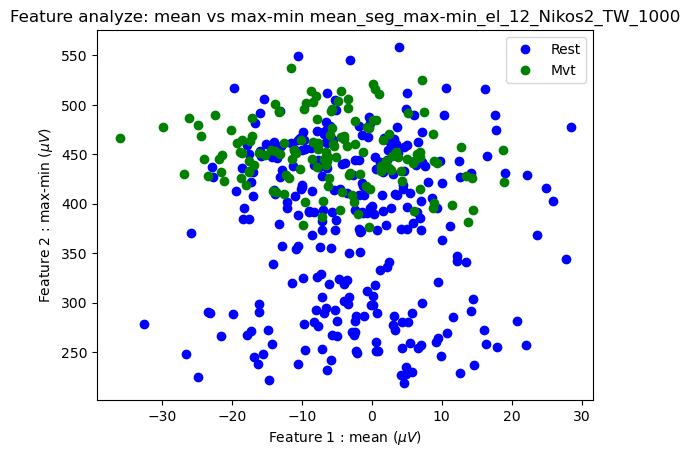

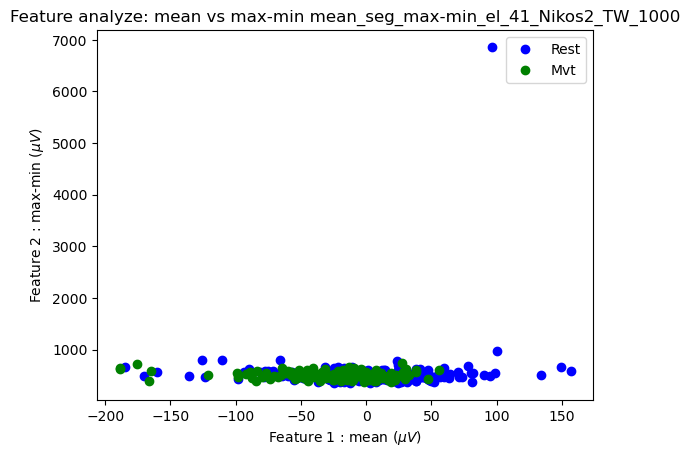

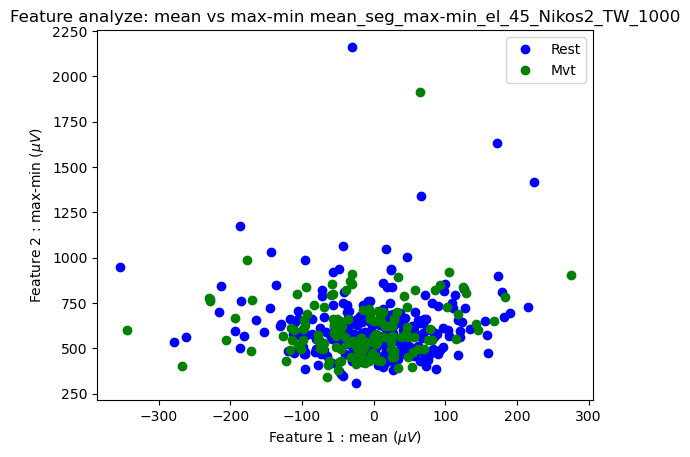

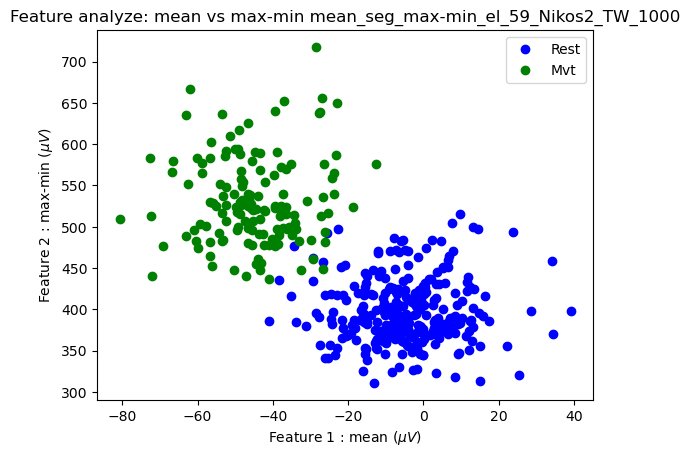

In [27]:
# Testing the model on 10 electrodes (5 Lilou and 5 Nikos)
path = "features/"
filenames = ['mean_seg_max-min_el_32_Lilou_TW_1000','mean_seg_max-min_el_45_Lilou_TW_1000',
             'mean_seg_max-min_el_54_Lilou_TW_1000','mean_seg_max-min_el_73_Lilou_TW_1000',
             'mean_seg_max-min_el_81_Lilou_TW_1000','mean_seg_max-min_el_2_Nikos2_TW_1000',
             'mean_seg_max-min_el_12_Nikos2_TW_1000','mean_seg_max-min_el_41_Nikos2_TW_1000',
             'mean_seg_max-min_el_45_Nikos2_TW_1000','mean_seg_max-min_el_59_Nikos2_TW_1000']


# Loop on each file
for filename in filenames :
    rest_mean_seg = []
    rest_max_min = []
    mvt_mean_seg = []
    mvt_max_min = []
    labels = []
    features = []
    predicted_labels = []

    # Read the csv file to extract the features and labels
    with open(path+filename+".csv",encoding="utf-8") as fobj: 
        reader = csv.reader(fobj) 
        colonnes = next(reader)
        idx_label = colonnes.index('label')
        idx_mean_seg = colonnes.index('mean_seg')
        idx_max_min = colonnes.index('max-min')
        idx_id_seg = colonnes.index('id_segment')
    
        for row in reader: 
            label = row[idx_label]
            mean_seg = float(row[idx_mean_seg][0:-3])
            max_min = float(row[idx_max_min][1:-4])
            id_seg = row[idx_id_seg]
    
            if label == 'rest':
                rest_mean_seg.append(mean_seg)
                rest_max_min.append(max_min)
            elif label == 'mvt':
                mvt_mean_seg.append(mean_seg)
                mvt_max_min.append(max_min)
    
            labels.append(label)
            features.append(np.array([mean_seg, max_min]))
    
            # Prediction of label
            predicted_label = clf1.predict([[mean_seg, max_min]])
            predicted_labels.append(predicted_label)
    
    print(filename)

    # Plotting to visualise features
    plt.figure()
    plt.plot(rest_mean_seg, rest_max_min, 'bo', label = 'Rest')
    plt.plot(mvt_mean_seg, mvt_max_min, 'go', label = 'Mvt')
    plt.xlabel('Feature 1 : mean ($\mu V$)')
    plt.ylabel('Feature 2 : max-min ($\mu V$)')
    plt.title('Feature analyze: mean vs max-min '+filename)
    plt.legend()
    #plt.savefig('figures/result_rest_mvt_'+filename+'_english.png')
    
    # Accuracy
    print('Accuracy: '+str(accuracy_score(labels, predicted_labels)))
    print('##########################################################################################')

# Analyzes 2 : Classify rest, reach-grasp, and pull movements
***

#### Again, let's read the csv file we made to extract the features and labels.

In [28]:
path = "features/"
filename = 'rest_all_mvts_el_2_Lilou_TW_250'

# Initialization
rest_mean_seg = []
rest_max_min = []
rest_mean_diff = []
reach_mean_seg = []
reach_max_min = []
reach_mean_diff = []
grasp_mean_seg = []
grasp_max_min = []
grasp_mean_diff = []
pull_mean_seg = []
pull_max_min = []
pull_mean_diff = []
hold_mean_seg = []
hold_max_min = []
hold_mean_diff = []
replace_mean_seg = []
replace_max_min = []
replace_mean_diff = []
release_mean_seg = []
release_max_min = []
release_mean_diff = []
labels = []
features1 = []
features2 = []
features3 = []

# Reading in the csv file to extract features and labels
with open(path+filename+".csv",encoding="utf-8") as fobj: 
    reader = csv.reader(fobj) 
    colonnes = next(reader)
    idx_label = colonnes.index('label')
    idx_mean_seg = colonnes.index('mean_seg')
    idx_max_min = colonnes.index('max-min')
    idx_mean_diff = colonnes.index('mean_diff')
    idx_id_seg = colonnes.index('id_segment')

    for row in reader: 
        label = row[idx_label]
        mean_seg = float(row[idx_mean_seg][0:-3])
        max_min = float(row[idx_max_min][1:-4])
        mean_diff = float(row[idx_mean_diff][0:-3])
        id_seg = row[idx_id_seg]

        # Identify the labels
        if label == 'rest':
            rest_mean_seg.append(mean_seg)
            rest_max_min.append(max_min)
            rest_mean_diff.append(mean_diff)
            
        elif label == 'reach':
            reach_mean_seg.append(mean_seg)
            reach_max_min.append(max_min)
            reach_mean_diff.append(mean_diff)

        elif label == 'grasp':
            grasp_mean_seg.append(mean_seg)
            grasp_max_min.append(max_min)
            grasp_mean_diff.append(mean_diff)

        elif label == 'pull':
            pull_mean_seg.append(mean_seg)
            pull_max_min.append(max_min)
            pull_mean_diff.append(mean_diff)

        elif label == 'hold':
            hold_mean_seg.append(mean_seg)
            hold_max_min.append(max_min)
            hold_mean_diff.append(mean_diff)

        elif label == 'replace':
            replace_mean_seg.append(mean_seg)
            replace_max_min.append(max_min)
            replace_mean_diff.append(mean_diff)

        elif label == 'release':
            release_mean_seg.append(mean_seg)
            release_max_min.append(max_min)
            release_mean_diff.append(mean_diff)

        # Here, the conditions are separated in 3: rest, reach-grasp, and pulling the object
        if label == 'rest':
            label_flag = True
        elif label in ['reach', 'grasp']:
            label = 'reach-grasp'
            label_flag = True
        elif label in ['pull', 'hold', 'replace']:
            label = 'pull'
            label_flag = True
        else : 
            label_flag = False

        if label_flag == True :
            labels.append(label)
            features1.append(np.array([mean_seg, max_min]))
            features2.append(np.array([mean_diff, max_min]))
            features3.append(np.array([mean_diff, mean_seg]))



Now, let's look at these features, to assess if they are revlevant to separate the rest, reach-grasp, and pulling conditions.

<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
/var/folders/8y/npl9c12x1pjf4438s29r9_9c0000gn/T/ipykernel_62552/3794160683.py:10: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Feature 1 : mean ($\mu V$)')
/var/folders/8y/npl9c12x1pjf4438s29r9_9c0000gn/T/ipykernel_62552/3794160683.py:11: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Feature 2 : max-min ($\mu V$)')


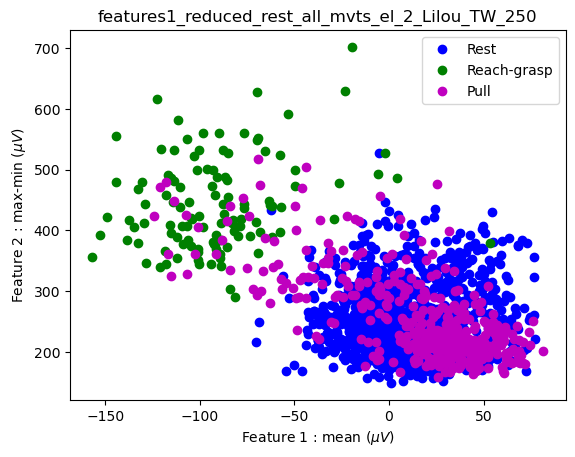

In [29]:
# Plotting to visualize the features for the different labels

plt.figure()
plt.plot(rest_mean_seg, rest_max_min, 'bo', label = 'Rest')
plt.plot(reach_mean_seg, reach_max_min, 'go', label = 'Reach-grasp')
plt.plot(grasp_mean_seg, grasp_max_min, 'go')
plt.plot(pull_mean_seg, pull_max_min, 'mo', label = 'Pull')
plt.plot(hold_mean_seg, hold_max_min, 'mo')
plt.plot(replace_mean_seg, replace_max_min, 'mo')
plt.xlabel('Feature 1 : mean ($\mu V$)')
plt.ylabel('Feature 2 : max-min ($\mu V$)')
plt.title('features1_reduced_'+filename)
plt.legend()
#plt.savefig('figures/result_analyze3_'+filename+'_english.png')


#### Now, let's train the model! 

In [30]:
# Training the model on Lilou el.4 data

# Implementation
clf2 = LinearDiscriminantAnalysis()

# Training
clf2.fit(features1, labels)

# Score (to give an idea of the separability of the data)
print(clf2.score(features1, labels))

0.748653500897666


#### Let's test the model on another electrode! 

<>:117: SyntaxWarning: invalid escape sequence '\m'
<>:118: SyntaxWarning: invalid escape sequence '\m'
<>:117: SyntaxWarning: invalid escape sequence '\m'
<>:118: SyntaxWarning: invalid escape sequence '\m'
/var/folders/8y/npl9c12x1pjf4438s29r9_9c0000gn/T/ipykernel_62552/504269496.py:117: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Feature 1 : mean ($\mu V$)')
/var/folders/8y/npl9c12x1pjf4438s29r9_9c0000gn/T/ipykernel_62552/504269496.py:118: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Feature 2 : max-min ($\mu V$)')


Accuracy: 0.7420706163973668
##########################################################################################


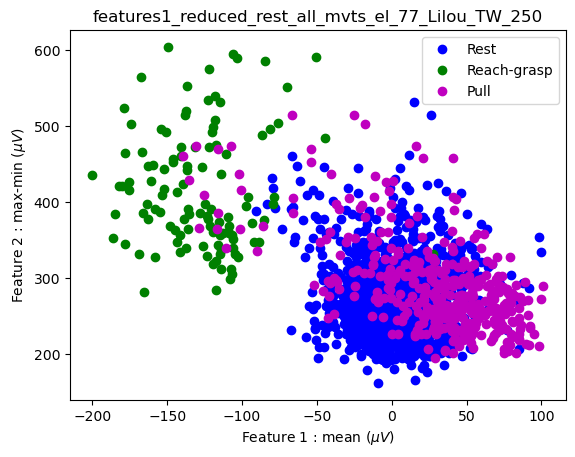

In [31]:
# Testing the model on Lilou el.77 data

path = "features/"
filenames = ['rest_all_mvts_el_77_Lilou_TW_250']

for filename in filenames :
    
    rest_mean_seg = []
    rest_max_min = []
    rest_mean_diff = []
    reach_mean_seg = []
    reach_max_min = []
    reach_mean_diff = []
    grasp_mean_seg = []
    grasp_max_min = []
    grasp_mean_diff = []
    pull_mean_seg = []
    pull_max_min = []
    pull_mean_diff = []
    hold_mean_seg = []
    hold_max_min = []
    hold_mean_diff = []
    replace_mean_seg = []
    replace_max_min = []
    replace_mean_diff = []
    release_mean_seg = []
    release_max_min = []
    release_mean_diff = []
    labels = []
    predicted_labels = []
    features1 = []
    features2 = []
    features3 = []

    # Read the csv file to extract the features and labels
    with open(path+filename+".csv",encoding="utf-8") as fobj: 
        reader = csv.reader(fobj) 
        colonnes = next(reader)
        idx_label = colonnes.index('label')
        idx_mean_seg = colonnes.index('mean_seg')
        idx_max_min = colonnes.index('max-min')
        idx_mean_diff = colonnes.index('mean_diff')
        idx_id_seg = colonnes.index('id_segment')
    
        for row in reader: 
            label = row[idx_label]
            mean_seg = float(row[idx_mean_seg][0:-3])
            max_min = float(row[idx_max_min][1:-4])
            mean_diff = float(row[idx_mean_diff][0:-3])
            id_seg = row[idx_id_seg]
    
            if label == 'rest':
                rest_mean_seg.append(mean_seg)
                rest_max_min.append(max_min)
                rest_mean_diff.append(mean_diff)
                
            elif label == 'reach':
                reach_mean_seg.append(mean_seg)
                reach_max_min.append(max_min)
                reach_mean_diff.append(mean_diff)
    
            elif label == 'grasp':
                grasp_mean_seg.append(mean_seg)
                grasp_max_min.append(max_min)
                grasp_mean_diff.append(mean_diff)
    
            elif label == 'pull':
                pull_mean_seg.append(mean_seg)
                pull_max_min.append(max_min)
                pull_mean_diff.append(mean_diff)
    
            elif label == 'hold':
                hold_mean_seg.append(mean_seg)
                hold_max_min.append(max_min)
                hold_mean_diff.append(mean_diff)
    
            elif label == 'replace':
                replace_mean_seg.append(mean_seg)
                replace_max_min.append(max_min)
                replace_mean_diff.append(mean_diff)
    
            elif label == 'release':
                release_mean_seg.append(mean_seg)
                release_max_min.append(max_min)
                release_mean_diff.append(mean_diff)
    
            if label == 'rest':
                label_flag = True
            elif label in ['reach', 'grasp']:
                label = 'reach-grasp'
                label_flag = True
            elif label in ['pull', 'hold', 'replace']:
                label = 'pull'
                label_flag = True
            else : 
                label_flag = False
    
            if label_flag == True :
                labels.append(label)
                features1.append(np.array([mean_seg, max_min]))
                features2.append(np.array([mean_diff, max_min]))
                features3.append(np.array([mean_diff, mean_seg]))

                # Prediction of label
                predicted_label = clf2.predict([[mean_seg, max_min]])
                predicted_labels.append(predicted_label)


    # Visualization
    plt.figure()
    plt.plot(rest_mean_seg, rest_max_min, 'bo', label = 'Rest')
    plt.plot(reach_mean_seg, reach_max_min, 'go', label = 'Reach-grasp')
    plt.plot(grasp_mean_seg, grasp_max_min, 'go')
    plt.plot(pull_mean_seg, pull_max_min, 'mo', label = 'Pull')
    plt.plot(hold_mean_seg, hold_max_min, 'mo')
    plt.plot(replace_mean_seg, replace_max_min, 'mo')
    plt.xlabel('Feature 1 : mean ($\mu V$)')
    plt.ylabel('Feature 2 : max-min ($\mu V$)')
    plt.title('features1_reduced_'+filename)
    plt.legend()
    #plt.savefig('figures/result_analyze3_'+filename+'_english.png')
        
    # Accuracy
    print('Accuracy: '+str(accuracy_score(labels, predicted_labels)))
    print('##########################################################################################')